# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory analysis</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev2 toc-item"><a href="#Pruned-range" data-toc-modified-id="Pruned-range-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pruned range</a></div><div class="lev2 toc-item"><a href="#Summary-statistics-of-NSRDB-vs-ground-based-measurements" data-toc-modified-id="Summary-statistics-of-NSRDB-vs-ground-based-measurements-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Summary statistics of NSRDB vs ground based measurements</a></div><div class="lev2 toc-item"><a href="#Clear-sky-periods" data-toc-modified-id="Clear-sky-periods-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clear sky periods</a></div><div class="lev2 toc-item"><a href="#Summary-statistics-for-clear-and-cloudy-periods" data-toc-modified-id="Summary-statistics-for-clear-and-cloudy-periods-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Summary statistics for clear and cloudy periods</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
nsrdb_df = pd.read_pickle('./srrl_nsrdb_df.pkl')
ground_df = pd.read_pickle('./srrl_ground_df.pkl')

# Exploratory analysis

## Find data overlap

In [3]:
nsrdb_df.index = nsrdb_df.index.tz_convert('UTC')

In [4]:
ground_df.index = ground_df.index.tz_convert('UTC')

In [5]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1998-01-01 00:00:00+00:00 -> 2015-12-31 23:30:00+00:00
Ground date range: 2009-01-01 07:01:00+00:00 -> 2015-01-01 06:59:00+00:00
Earliest intersection: 2009-01-01 07:30:00+00:00, latest intersection: 2015-01-01 06:30:00+00:00


<IPython.core.display.Javascript object>


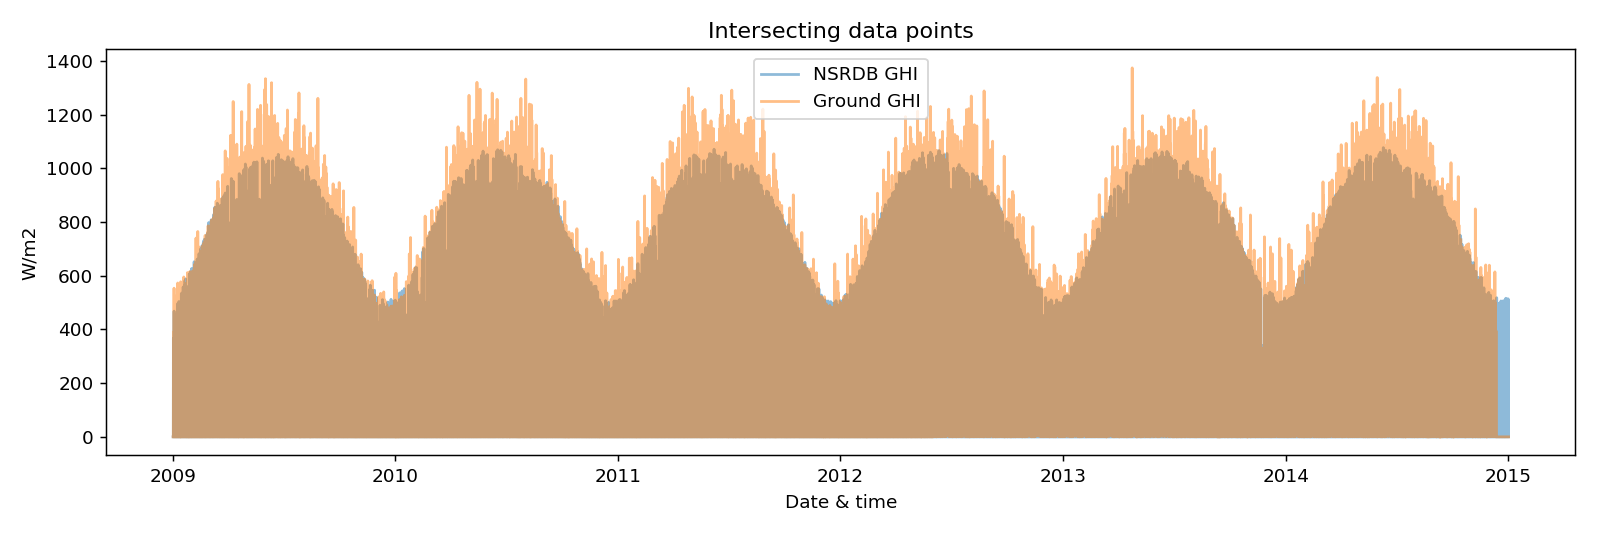

In [6]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')

p2 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

Lots of overlap which is great.  SRRL data looks strange though - it has no seasonality.

## Pruned range

<IPython.core.display.Javascript object>


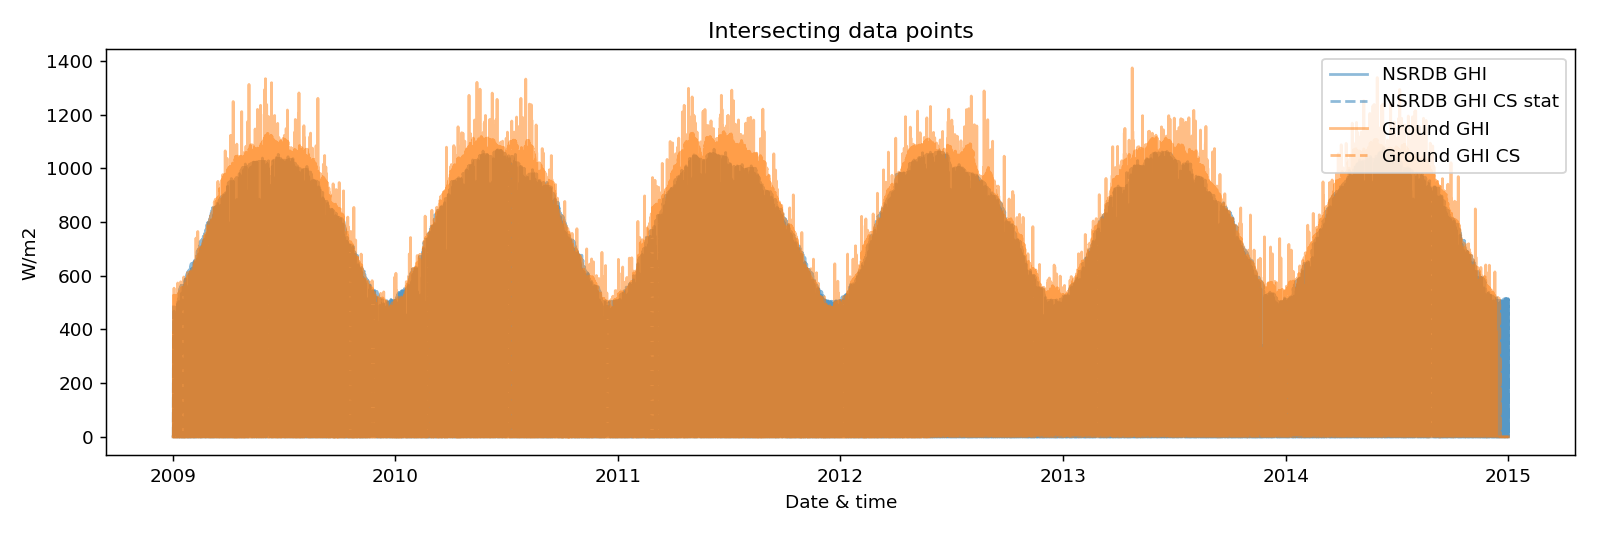

In [7]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=.5, label='NSRDB GHI CS stat', color=p1[0].get_color(), linestyle='--')

p3 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')
p4 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=.5, label='Ground GHI CS', color=p3[0].get_color(), linestyle='--')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

## Summary statistics of NSRDB vs ground based measurements

In [8]:
val = utils.mean_abs_diff(nsrdb_df.loc[intersection]['GHI'], ground_df.loc[intersection]['GHI'])
print('Mean absolute difference of measured GHI: ', val)
val = utils.mean_abs_diff(nsrdb_df.loc[intersection]['Clearsky GHI stat'], ground_df.loc[intersection]['Clearsky GHI stat'])
print('Mean absolute difference of modeled GHI: ', val)

Mean absolute difference of measured GHI:  41.8148643763
Mean absolute difference of modeled GHI:  16.5636757195


Measured GHI is quite off between SRRL and NSRDB.  This likely dominated by the mismatch due to no seasonality in the SRRL data.

## Clear sky periods

<IPython.core.display.Javascript object>


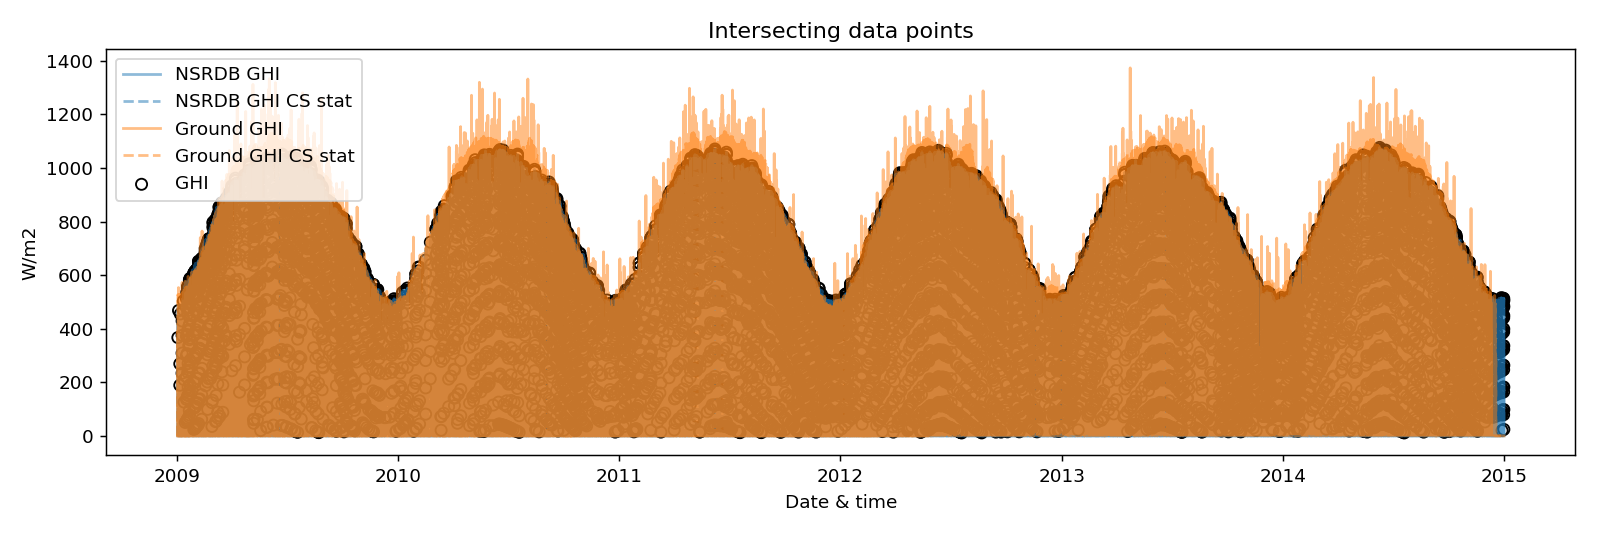

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [9]:
fig, ax = plt.subplots(figsize=(12,4))

p1 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['GHI'], 
             alpha=.5, label='NSRDB GHI')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=.5, label='NSRDB GHI CS stat', color=p1[0].get_color(), linestyle='--')

p3 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['GHI'], 
             alpha=.5, label='Ground GHI')
p4 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=.5, label='Ground GHI CS stat', color=p3[0].get_color(), linestyle='--')

p5 = ax.scatter(nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index,
                nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1]['GHI'],
                marker='o', edgecolor='black', facecolor='none')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

SRRL and NSRDB data don't seem to match as well as the Sandia RTC and NSRDB.

## Summary statistics for clear and cloudy periods

In [10]:
clear_mask = nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index
cloudy_mask = nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 0].index

# MAD between NSRDB and RTC values during clear periods (from NSRDB)
nsrdb_ghi_clear = nsrdb_df.loc[intersection].loc[clear_mask]['GHI']
ground_ghi_clear = ground_df.loc[intersection].loc[clear_mask]['GHI']
print('Clear period mean abs diff between NSRDB, RTC: ', utils.mean_abs_diff(nsrdb_ghi_clear, ground_ghi_clear))

# MAD between NSRDB and RTC values during cloudy periods (from NSRDB)
nsrdb_ghi_cloudy = nsrdb_df.loc[intersection].loc[cloudy_mask]['GHI']
ground_ghi_cloudy = ground_df.loc[intersection].loc[cloudy_mask]['GHI']
print('Cloudy period mean_abs_diff between NSRDB, RTC: ', utils.mean_abs_diff(nsrdb_ghi_cloudy, ground_ghi_cloudy))

# Ratio of measured to modeled irradiance (NSRDB) during clear periods (from NSRDB)
nsrdb_ghi_model_clear = nsrdb_df.loc[intersection].loc[clear_mask]['Clearsky GHI stat']
ground_ghi_model_clear = ground_df.loc[intersection].loc[clear_mask]['Clearsky GHI stat']

nsrdb_ghi_model_cloudy = nsrdb_df.loc[intersection].loc[cloudy_mask]['Clearsky GHI stat']
ground_ghi_model_cloudy = ground_df.loc[intersection].loc[cloudy_mask]['Clearsky GHI stat']

print('---' * 20)

print('Clear period GHI:Clearsky GHI ratio - NSRDB: ', 
      np.mean(nsrdb_ghi_clear / nsrdb_ghi_model_clear), ' +/- ',
      np.std(nsrdb_ghi_clear / nsrdb_ghi_model_clear))

print('Clear period GHI:Clearsky GHI ratio - ground: ', 
      np.mean((ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std((ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)))

print('Cloudy period GHI:Clearsky GHI ratio - NSRDB: ', 
      np.mean(nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy), ' +/- ',
      np.std(nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy))

print('Cloudy period GHI:Clearsky GHI ratio - ground: ', 
      np.mean((ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std((ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)))

print('---' * 20)

print('Clear period mean abs ratio diff from 1 - NSRDB: ', 
      np.mean(np.abs(1 - nsrdb_ghi_clear / nsrdb_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std(np.abs(1 - nsrdb_ghi_clear / nsrdb_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0)))

print('Clear period mean abs ratio diff from 1 - ground: ', 
      np.mean(np.abs(1 - (ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0))), ' +/- ',
      np.std(np.abs(1 - (ground_ghi_clear / ground_ghi_model_clear).replace([-np.inf, np.inf, np.nan,], 0))))

print('Cloudy period mean abs ratio diff from 1 - NSRDB: ', 
      np.mean(np.abs(1 - nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)), ' +/- ',
      np.std(np.abs(1 - nsrdb_ghi_cloudy / nsrdb_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0)))

print('cloudy period mean abs ratio diff from 1 - ground: ', 
      np.mean(np.abs(1 - (ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0))), ' +/- ',
      np.std(np.abs(1 - (ground_ghi_cloudy / ground_ghi_model_cloudy).replace([-np.inf, np.inf, np.nan,], 0))))

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Clear period mean abs diff between NSRDB, RTC:  28.6838319378
Cloudy period mean_abs_diff between NSRDB, RTC:  44.0567729203
------------------------------------------------------------
Clear period GHI:Clearsky GHI ratio - NSRDB:  0.971061294983  +/-  0.0595700716685
Clear period GHI:Clearsky GHI ratio - ground:  0.889503181761  +/-  0.183091145175
Cloudy period GHI:Clearsky GHI ratio - NSRDB:  0.584143390588  +/-  0.315957226988
Cloudy period GHI:Clearsky GHI ratio - ground:  0.408977055863  +/-  0.517356217232
------------------------------------------------------------
Clear period mean abs ratio diff from 1 - NSRDB:  0.0364207004474  +/-  0.0553134221104
Clear period mean abs ratio diff from 1 - ground:  0.115626298097  +/-  0.17989572944
Cloudy period mean abs ratio diff from 1 - NSRDB:  0.174712396684  +/-  0.28909659219
cloudy period mean abs ratio diff from 1 - ground:  0.61563078937  +/-  0.487815853766


<IPython.core.display.Javascript object>


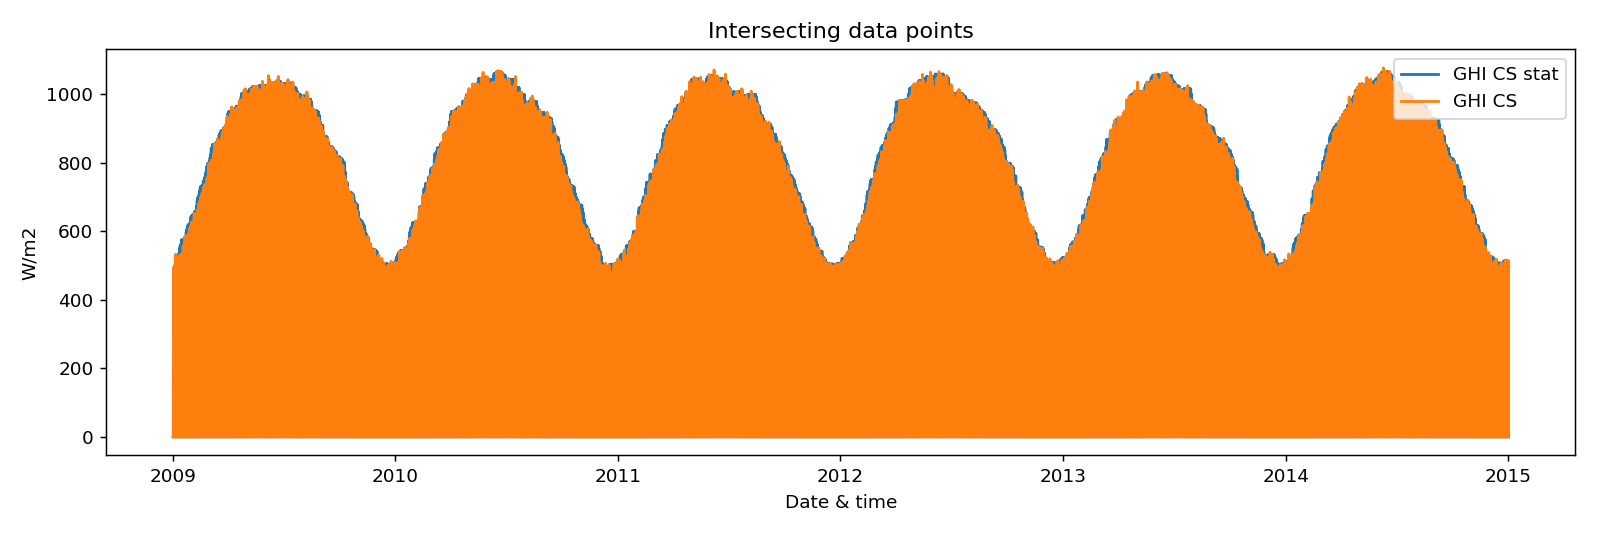

In [11]:
fig, ax = plt.subplots(figsize=(12,4))

# p1 = ax.plot(nsrdb_df.loc[intersection].index, 
#              nsrdb_df.loc[intersection]['GHI'], 
#              alpha=.5, label='NSRDB GHI')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=1, label='GHI CS stat')
p2 = ax.plot(nsrdb_df.loc[intersection].index, 
             nsrdb_df.loc[intersection]['Clearsky GHI'], 
             alpha=1, label='GHI CS')

# p3 = ax.plot(ground_df.loc[intersection].index, 
#              ground_df.loc[intersection]['GHI'], 
#              alpha=.5, label='Ground GHI')
# p4 = ax.plot(ground_df.loc[intersection].index, 
#              ground_df.loc[intersection]['Clearsky GHI stat'], 
#              alpha=.5, label='Ground GHI CS stat', color=p3[0].get_color(), linestyle='--')

# p5 = ax.scatter(nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index,
#                 nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1]['GHI'],
#                 marker='o', edgecolor='black', facecolor='none')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

In [12]:
utils.mean_abs_diff(nsrdb_df['Clearsky GHI'], nsrdb_df['Clearsky GHI stat'])

8.338767303011867

<IPython.core.display.Javascript object>


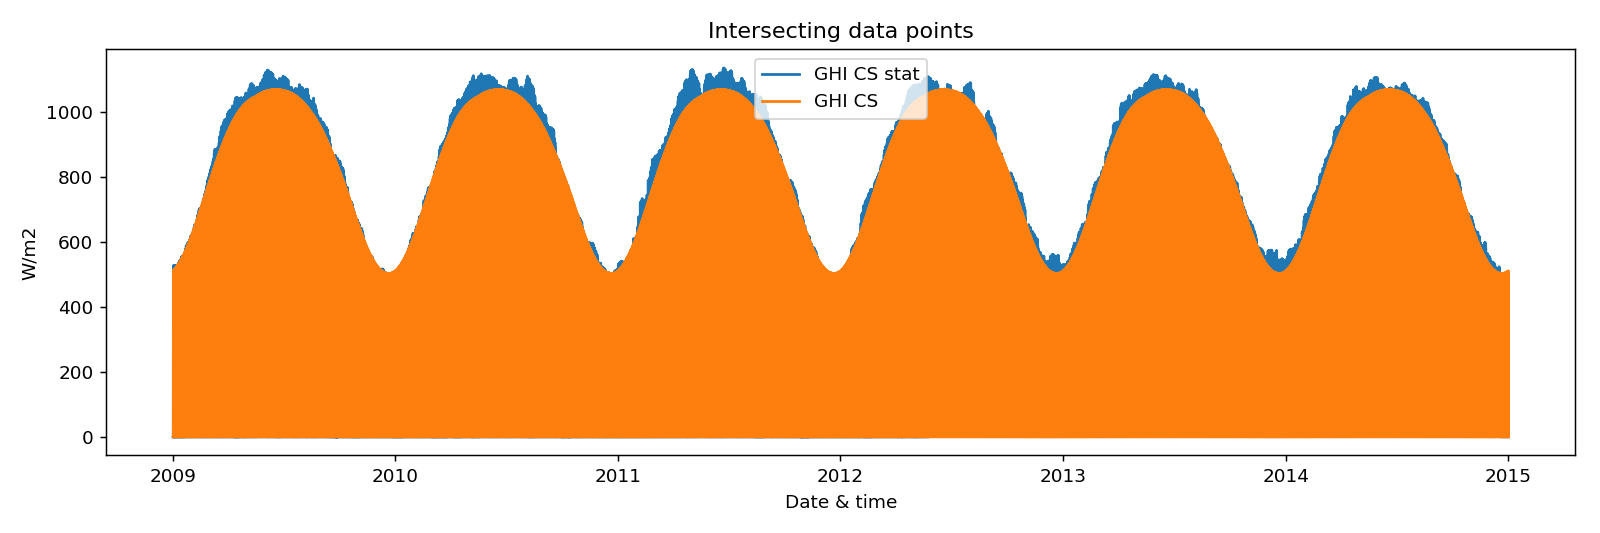

In [13]:
fig, ax = plt.subplots(figsize=(12,4))

# p1 = ax.plot(nsrdb_df.loc[intersection].index, 
#              nsrdb_df.loc[intersection]['GHI'], 
#              alpha=.5, label='NSRDB GHI')
p2 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI stat'], 
             alpha=1, label='GHI CS stat')
p2 = ax.plot(ground_df.loc[intersection].index, 
             ground_df.loc[intersection]['Clearsky GHI'], 
             alpha=1, label='GHI CS')

# p3 = ax.plot(ground_df.loc[intersection].index, 
#              ground_df.loc[intersection]['GHI'], 
#              alpha=.5, label='Ground GHI')
# p4 = ax.plot(ground_df.loc[intersection].index, 
#              ground_df.loc[intersection]['Clearsky GHI stat'], 
#              alpha=.5, label='Ground GHI CS stat', color=p3[0].get_color(), linestyle='--')

# p5 = ax.scatter(nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1].index,
#                 nsrdb_df.loc[intersection][nsrdb_df['sky_status'] == 1]['GHI'],
#                 marker='o', edgecolor='black', facecolor='none')

_ = ax.set_title('Intersecting data points')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')

_ = ax.legend()

_ = fig.tight_layout()

In [14]:
utils.mean_abs_diff(ground_df['Clearsky GHI'], ground_df['Clearsky GHI stat'])

13.371699021002241